In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
'''
定义工具函数
'''

def get_drawdown(p):
    """
    计算净值回撤
    """
    T = len(p)
    hmax = [p[0]]
    for t in range(1, T):
        hmax.append(np.nanmax([p[t], hmax[t - 1]]))
    dd = [p[t] / hmax[t] - 1 for t in range(T)]

    return dd


def cal_period_perf_indicator(adjnav):
    """
    计算区间业绩指标
    """

    if type(adjnav) == pd.DataFrame:
        res = pd.DataFrame(index=adjnav.columns, columns=['AnnRet', 'AnnVol', 'SR', 'MaxDD', 'Calmar'])
        for col in adjnav:
            res.loc[col] = cal_period_perf_indicator(adjnav[col])

        return res

    ret = adjnav.pct_change()
    annret = np.nanmean(ret) * 242
    annvol = np.nanstd(ret) * np.sqrt(242)
    sr = annret / annvol
    dd = get_drawdown(adjnav)
    mdd = np.nanmin(dd)
    calmar = annret / -mdd

    return [annret, annvol, sr, mdd, calmar]


def datestr2dtdate(datestr):
    # 日期格式转换：'yyyy-mm-dd'转为datetime.date
    return datetime.datetime.strptime(datestr, '%Y-%m-%d').date()


def date_count_in_mouth(dates):
    # 计算日期序列中每个日期在所在月中的序数
    cur_count = 1
    counts = [cur_count]
    for i in range(1,len(dates)):
        if dates[i].month == dates[i-1].month:
            cur_count = cur_count + 1
        else:
            cur_count = 1
        counts.append(cur_count)
    return counts


In [6]:
'''
main
'''

# 从csv文件获取指数价格数据
index_data = pd.read_csv('./指数历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

# 设置回测参数
index_id = 'hs300' # 标的指数：'hs300' or 'csi500' or 'csi1000'
start_date = datetime.date(2012,1,1) # 回测起始日期
end_date = datetime.date(2021,7,27) # 回测截止日期
t1 = 1  # 每月持仓交易起始日，从1起
t2 = 5 # 每月持仓交易截止日，从1起

index_data

,csi1000,csi500,hs300
2004-12-31,1000.0000,1000.0000,1000.0000
2005-01-04,989.9840,986.9270,982.7940
2005-01-05,1013.5830,1003.6330,992.5640
2005-01-06,1005.4650,994.5950,983.1740
2005-01-07,1011.7400,997.6060,983.9580
...,...,...,...
2021-08-12,7657.5268,7095.2024,4973.3509
2021-08-13,7641.9169,7088.8876,4945.9829
2021-08-16,7568.1374,7052.4876,4941.0676
2021-08-17,7360.0330,6894.4042,4837.4034


In [7]:
# 回测
df = index_data.loc[start_date:end_date,[index_id]]
df['index_ret'] = df[index_id].pct_change()
df['index'] = (1+df['index_ret']).cumprod()
df['date_count_in_month'] = date_count_in_mouth(df.index)
df['pos'] = [1 if (e>=t1 and e<=t2) else 0 for e in df['date_count_in_month']] # 昨收仓位
df['stgy_ret'] = df['pos'] * df['index_ret']
df['stgy'] = (1+df['stgy_ret']).cumprod()

df

,hs300,index_ret,index,date_count_in_month,pos,stgy_ret,stgy
2012-01-04,2298.7530,NaN,NaN,1,1,NaN,NaN
2012-01-05,2276.3850,-0.009730,0.990270,2,1,-0.009730,0.990270
2012-01-06,2290.6010,0.006245,0.996454,3,1,0.006245,0.996454
2012-01-09,2368.5700,0.034039,1.030372,4,1,0.034039,1.030372
2012-01-10,2447.3490,0.033260,1.064642,5,1,0.033260,1.064642
...,...,...,...,...,...,...,...
2021-07-21,5144.0428,0.006860,2.237754,15,0,0.000000,2.575939
2021-07-22,5151.7517,0.001499,2.241107,16,0,0.000000,2.575939
2021-07-23,5089.2282,-0.012136,2.213908,17,0,-0.000000,2.575939
2021-07-26,4925.2990,-0.032211,2.142596,18,0,-0.000000,2.575939


         AnnRet    AnnVol        SR     MaxDD    Calmar
index  0.102206  0.225321  0.453603 -0.466961  0.218875
stgy   0.106254  0.114998  0.923959 -0.183745  0.578268


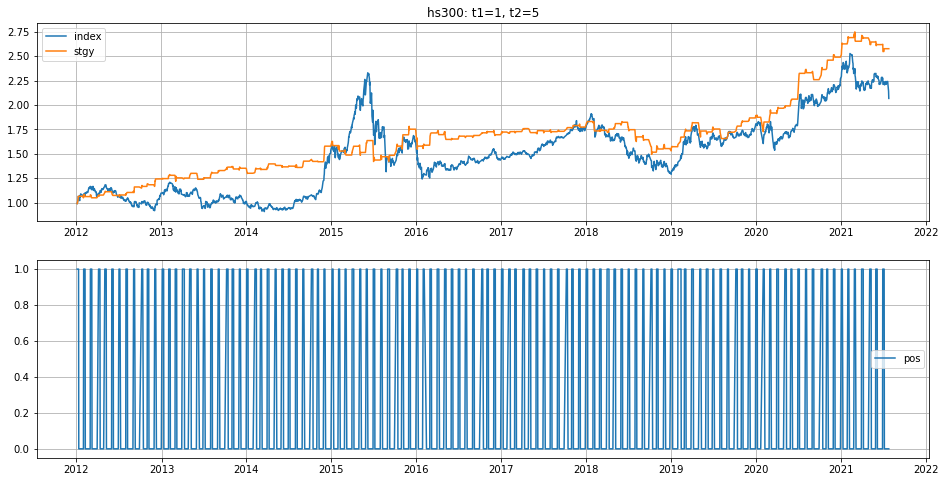

In [5]:
# 回测结果展示
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(2,1,1)
df.loc[:,['index','stgy']].plot(ax=ax1, grid=True, title='%s: t1=%d, t2=%d' % (index_id,t1,t2))
ax2 = fig.add_subplot(2,1,2)
df.loc[:,['pos']].plot(ax=ax2, grid=True)
res = cal_period_perf_indicator(df.loc[:,['index','stgy']])
print(res)